In [ ]:
import requests

# URL-адреса для файлов
weights_url = "https://pjreddie.com/media/files/yolov3.weights"
cfg_url = "https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true"
names_url = "https://github.com/pjreddie/darknet/blob/master/data/coco.names?raw=true"

# Функция для загрузки файлов
def download_file(url, filename):
    with open(filename, 'wb') as file:
        response = requests.get(url, stream=True)
        file.write(response.content)

# Загрузка файлов
download_file(weights_url, 'yolov3.weights')
download_file(cfg_url, 'yolov3.cfg')
download_file(names_url, 'coco.names')


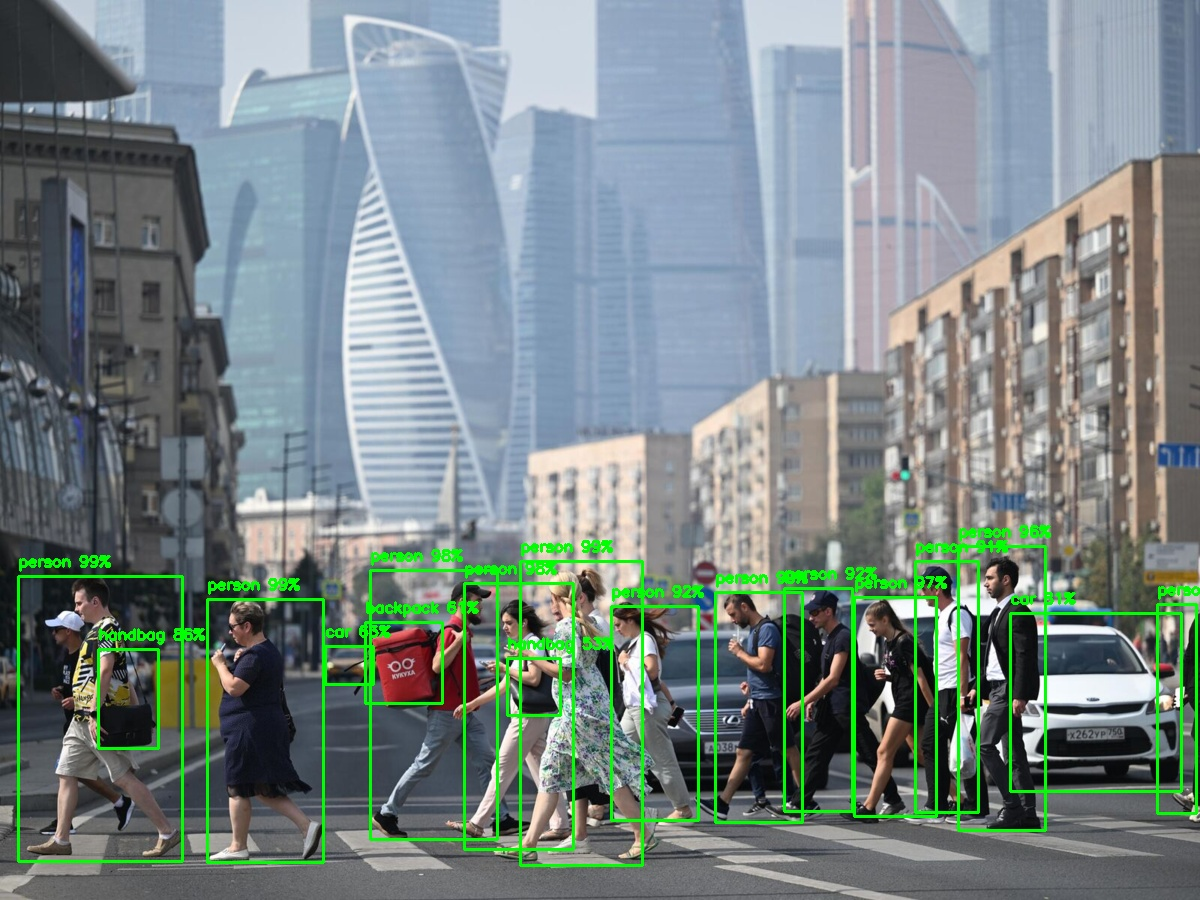

In [ ]:
import cv2
import numpy as np

# Загрузка модели YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# Загрузка классов из файла coco.names
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Загрузка изображения
image_path = "/content/photo.png"
image = cv2.imread(image_path)
height, width, channels = image.shape

# Подготовка изображения для YOLO
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)

# Обнаружение объектов
outs = net.forward(output_layers)

# Для NMS
boxes = []
confidences = []
class_ids = []

# Отображение результатов
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Обнаружение объекта
            center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Применение Non-max Suppression для удаления избыточных прогнозов, и выбора самого точного
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.45)

# Рисование ограничивающих рамок
for i in indexes.flatten():
    x, y, w, h = boxes[i]
    label = str(classes[class_ids[i]])
    confidence = confidences[i]
    color = [0, 255, 0]
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    cv2.putText(image, f"{label} {int(confidence * 100)}%", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Сохранение и отображение результата
result_image_path = "/content/detected_objects.jpg"
cv2.imwrite(result_image_path, image)

# Просмотр результата
from IPython.display import Image, display
display(Image(filename=result_image_path))
